## Installing required libraries



In [27]:
!pip install kaggle
!pip install imblearn

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


## Imports

In [63]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from imblearn.under_sampling import RandomUnderSampler
from imblearn.over_sampling import RandomOverSampler

## Fetching data from Kaggle

The dataset is a Kaggle dataset called [_Audio features and lyrics of Spotify songs_](https://www.kaggle.com/datasets/imuhammad/audio-features-and-lyrics-of-spotify-songs).

This dataset contains various types of information of over more that 18000 Spotify songs including, artist, album, audio features (e.g. loudness), lyrics, the language of lyrics, genres and sub-genres.

The original dataset was used in the [third week of the TidyTeusday project](https://github.com/rfordatascience/tidytuesday/tree/master/data/2020/2020-01-21) and only contained audio features and genres. The lyrics were added to the dataset using the [`genius`](https://cran.r-project.org/web/packages/genius/index.html) library in R, and the language of the lyrics were included using the [`langdetect`](https://pypi.org/project/langdetect/) library in python. However, only around half of the original songs are available in this dataset as lyrics could not be retreived for many songs.

In [3]:
from google.colab import files 
files.upload()

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"slothonmeth","key":"cd262fc091f9601cd35187e083b17459"}'}

In [4]:
! mkdir ~/.kaggle
! cp kaggle.json ~/.kaggle/
! chmod 600 ~/.kaggle/kaggle.json

In [5]:
! kaggle datasets download -d imuhammad/audio-features-and-lyrics-of-spotify-songs
! unzip audio-features-and-lyrics-of-spotify-songs.zip -d data

 41% 5.00M/12.3M [00:00<00:00, 22.1MB/s]
100% 12.3M/12.3M [00:00<00:00, 48.8MB/s]
Archive:  audio-features-and-lyrics-of-spotify-songs.zip
  inflating: data/spotify_songs.csv  


## Getting to know the Dataset

In [52]:
data = pd.read_csv('data/spotify_songs.csv')

### Dataset statistics

The dataset has 18454 unique tracks from 6031 unique artists

In [34]:
data.describe(include='all')[:2]

,track_id,track_name,track_artist,lyrics,track_popularity,track_album_id,track_album_name,track_album_release_date,playlist_name,playlist_id,...,loudness,mode,speechiness,acousticness,instrumentalness,liveness,valence,tempo,duration_ms,language
count,18454,18454,18454,18194,18454.0,18454,18454,18454,18454,18454,...,18454.0,18454.0,18454.0,18454.0,18454.0,18454.0,18454.0,18454.0,18454.0,18194
unique,18454,15198,6031,15977,NaN,14278,12671,3817,442,464,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,34


In [35]:
data.head()

,track_id,track_name,track_artist,lyrics,track_popularity,track_album_id,track_album_name,track_album_release_date,playlist_name,playlist_id,...,loudness,mode,speechiness,acousticness,instrumentalness,liveness,valence,tempo,duration_ms,language
0,0017A6SJgTbfQVU2EtsPNo,Pangarap,Barbie's Cradle,Minsan pa Nang ako'y napalingon Hindi ko alam ...,41,1srJQ0njEQgd8w4XSqI4JQ,Trip,2001-01-01,Pinoy Classic Rock,37i9dQZF1DWYDQ8wBxd7xt,...,-10.068,1,0.0236,0.27900,0.01170,0.0887,0.566,97.091,235440,tl
1,004s3t0ONYlzxII9PLgU6z,I Feel Alive,Steady Rollin,"The trees, are singing in the wind The sky blu...",28,3z04Lb9Dsilqw68SHt6jLB,Love & Loss,2017-11-21,Hard Rock Workout,3YouF0u7waJnolytf9JCXf,...,-4.739,1,0.0442,0.01170,0.00994,0.3470,0.404,135.225,373512,en
2,00chLpzhgVjxs1zKC9UScL,Poison,Bell Biv DeVoe,"NA Yeah, Spyderman and Freeze in full effect U...",0,6oZ6brjB8x3GoeSYdwJdPc,Gold,2005-01-01,"Back in the day - R&B, New Jack Swing, Swingbe...",3a9y4eeCJRmG9p4YKfqYIx,...,-7.504,0,0.2160,0.00432,0.00723,0.4890,0.650,111.904,262467,en
3,00cqd6ZsSkLZqGMlQCR0Zo,Baby It's Cold Outside (feat. Christina Aguilera),CeeLo Green,I really can't stay Baby it's cold outside I'v...,41,3ssspRe42CXkhPxdc12xcp,CeeLo's Magic Moment,2012-10-29,Christmas Soul,6FZYc2BvF7tColxO8PBShV,...,-5.819,0,0.0341,0.68900,0.00000,0.0664,0.405,118.593,243067,en
4,00emjlCv9azBN0fzuuyLqy,Dumb Litty,KARD,Get up out of my business You don't keep me fr...,65,7h5X3xhh3peIK9Y0qI5hbK,KARD 2nd Digital Single ‘Dumb Litty’,2019-09-22,K-Party Dance Mix,37i9dQZF1DX4RDXswvP6Mj,...,-1.993,1,0.0409,0.03700,0.00000,0.1380,0.240,130.018,193160,en


In [36]:
data.dtypes

track_id                     object
track_name                   object
track_artist                 object
lyrics                       object
track_popularity              int64
track_album_id               object
track_album_name             object
track_album_release_date     object
playlist_name                object
playlist_id                  object
playlist_genre               object
playlist_subgenre            object
danceability                float64
energy                      float64
key                           int64
loudness                    float64
mode                          int64
speechiness                 float64
acousticness                float64
instrumentalness            float64
liveness                    float64
valence                     float64
tempo                       float64
duration_ms                   int64
language                     object
dtype: object

### Track languages

The dataset has predominantly english songs - around ~84% of total songs



In [37]:
data['language'].value_counts()

en    15405
es     1705
de      241
pt      176
it      133
pl       76
nl       72
fr       65
tl       63
da       40
id       34
ko       29
vi       24
so       16
sw       16
ro       16
cy       12
no       10
hi       10
ja        8
et        7
tr        5
sv        5
af        5
ru        4
sq        3
hr        3
ar        2
cs        2
ca        2
el        2
hu        1
fi        1
sk        1
Name: language, dtype: int64

### Track genres

In the dataset, the genre of a music track is determined to be the genre of the playlist it is a part of.

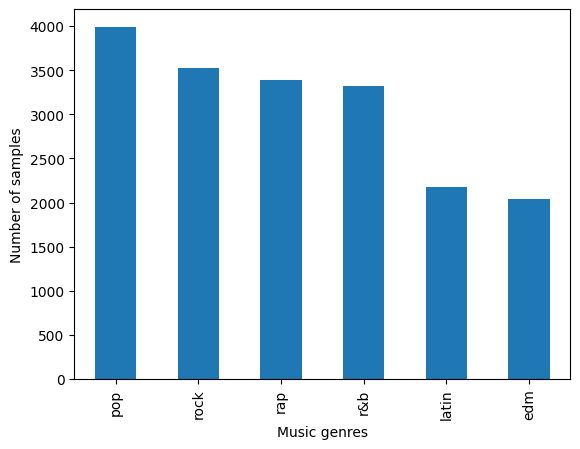

In [53]:
count = data['playlist_genre'].value_counts()
count.plot.bar()
plt.ylabel('Number of samples')
plt.xlabel('Music genres')
plt.show()

## Preprocessing

### Drop non-english songs
There are no good word embeddings available for non-english songs; in addition, only ~16% of total data samples are non-english

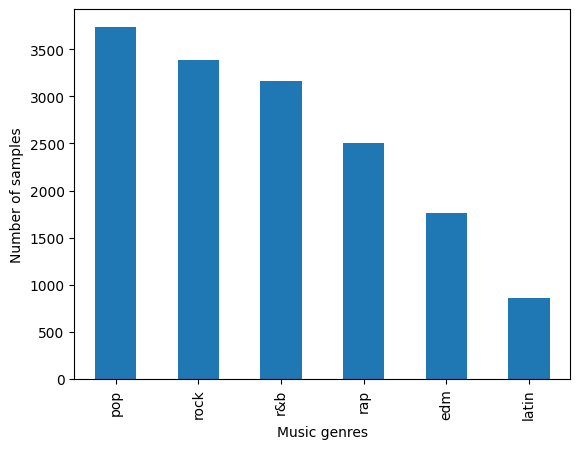

In [54]:
data = data.loc[data['language'] == 'en']

count = data['playlist_genre'].value_counts()
count.plot.bar()
plt.ylabel('Number of samples')
plt.xlabel('Music genres')
plt.show()

### Remove `latin` songs
We do not have enough samples for `latin`

In [55]:
data = data.loc[data['playlist_genre'] != 'latin']
data['playlist_genre'].value_counts()

pop     3739
rock    3388
r&b     3161
rap     2502
edm     1758
Name: playlist_genre, dtype: int64

### Drop unusable features

Features like `track_id`, `track_artist`, `track_album_id`, `playlist_id` are not realistically expected to provide any information regarding a music track's genre

In [56]:
data.drop(
    ['track_id', 'track_name', 'track_artist', 'track_album_id', 'track_album_name', 'track_album_release_date', 'playlist_name', 'playlist_id', 'playlist_subgenre', 'language'],
    axis=1,
    inplace=True
)
data.dtypes

lyrics               object
track_popularity      int64
playlist_genre       object
danceability        float64
energy              float64
key                   int64
loudness            float64
mode                  int64
speechiness         float64
acousticness        float64
instrumentalness    float64
liveness            float64
valence             float64
tempo               float64
duration_ms           int64
dtype: object

Now we can split our dataset into `X` (input) and `y` (target labels) - here, our target labels are the values in the column `playlist_genre`

In [57]:
X = data.loc[:, data.columns != 'playlist_genre']
y = data['playlist_genre']

### Balance the dataset

We will be balancing the data such that we will have 3K samples for each genre by doing random undersampling and oversampling

In [58]:
n_samples = 3000

def sampling_strategy(labels, n_samples, sampling_type):
    target_labels = ''
    if sampling_type == 'undersampling':
        target_labels = labels.value_counts() > n_samples
    elif sampling_type == 'oversampling':
        target_labels = labels.value_counts() < n_samples
    tl = target_labels[target_labels == True].index
    sampling_strategy = {}
    for target in tl:
        sampling_strategy[target] = n_samples
    return sampling_strategy

#### Undersampling majority classes

In [62]:
under_sampler = RandomUnderSampler(sampling_strategy=sampling_strategy(y, n_samples, 'undersampling'))
X_under, y_under = under_sampler.fit_resample(X, y)

#### Oversampling minority classes

In [64]:
over_sampler = RandomOverSampler(sampling_strategy=sampling_strategy(y_under, n_samples, 'oversampling'))
X_bal, y_bal = over_sampler.fit_resample(X_under, y_under)

The new dataset now has 3000 samples for each genre

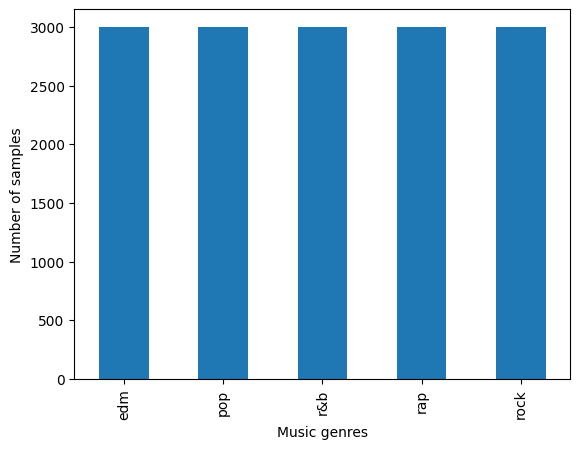

In [65]:
count = y_bal.value_counts()
count.plot.bar()
plt.ylabel('Number of samples')
plt.xlabel('Music genres')
plt.show()